## Visualization 4: Relationship between NBA Player of the Week and Other Awards/Honors

In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)

import pandas as pd
import numpy as np

### Load Datasets: Player of the Week & Summary

In [2]:
## Player of week
POTW = pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv')
POTW = POTW.loc[POTW['Season short'] > 1990]

In [3]:
## Summary
SUM = pd.read_csv('../data/scraped/NBA_Yearly_Summary.csv')

In [4]:
# Person who get most times POTW each year
POTW_count = POTW.groupby(['Season short','Player','Team']).count()['Date'].reset_index().rename(columns = {'Date': 'POTW_Count'})
max_count = POTW_count.groupby('Season short').max()[['POTW_Count']].reset_index().rename(columns = {'POTW_Count': 'Max'})
potw_max = pd.merge(max_count, POTW_count, on = ['Season short'])
potw_max = potw_max.loc[potw_max.Max == potw_max.POTW_Count].drop(columns = 'POTW_Count')

In [5]:
# Join Tables
potw_title = pd.merge(potw_max,SUM, left_on = 'Season short', right_on= 'Year',how = 'left').drop(columns = 'Season short')

In [6]:
# function to confirm whether the player got other titles
def confirm(df, column1, column2):
    df.loc[df[column1] != df[column2], column2] = 0
    df.loc[df[column1] == df[column2], column2] = 1 
    return df

In [7]:
# Whether the person who got most time player of the week also got other titles?
for col in potw_title.columns[-6:]:
    potw_title = confirm(potw_title,'Player',str(col))

In [8]:
# Maybe Some Max POTW didn't get any titles?
cols = potw_title.columns[-6:]
potw_title['Neither'] = potw_title[cols].sum(axis=1)
potw_title.loc[potw_title['Neither'] != 0, 'Neither'] = 'either'
potw_title.loc[potw_title['Neither'] == 0, 'Neither'] = 'neither'
potw_title.loc[potw_title['Neither'] == 'neither', 'Neither'] = 1
potw_title.loc[potw_title['Neither'] == 'either', 'Neither'] = 0

In [9]:
# Restructure the Table and Rename the columns
potw_title_new = (potw_title.groupby(['Year','Player','Team','Max'])
                  .sum().stack().reset_index())
potw_title_new.columns = ['Year','Player','Team','POTW_Times','Title','Whether']
# Get the Rows Where Max POTW got titles
potw_title_new = potw_title_new.loc[potw_title_new.Whether == 1]

In [10]:
# Set Categorical Variables and thus give the order to the titles
title = ['Most Valuable Player','PPG Leader','WS Leader','RPG Leader','APG Leader','Rookie of the Year','Neither']
potw_title_new.Title = potw_title_new.Title.astype(pd.api.types.CategoricalDtype(categories = title, ordered = True), )
potw_title_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 6 to 448
Data columns (total 6 columns):
Year          89 non-null int64
Player        89 non-null object
Team          89 non-null object
POTW_Times    89 non-null int64
Title         89 non-null category
Whether       89 non-null int64
dtypes: category(1), int64(3), object(2)
memory usage: 4.6+ KB


In [11]:
# Drop the column Neither As there would be overlapped labels and hard for visualization
potw_title_2 = potw_title_new.loc[potw_title_new.Title != 'Neither'].reset_index(drop = True)

### Visualization in R

In [12]:
%R -i potw_title_new
%R -i potw_title_2

In [13]:
%%R -w 12 -h 10 --units in -r 300
season <- function(x) {
    paste(x - 1, '-', x)
}

no_potw_label <- 'No POTW received other NBA titles that season'

ggplot(data = potw_title_2) + 
geom_label(aes(x = Year, y = Title, label = Player, fill = Player),family = 'Avenir Next',alpha = 0.5) +
geom_rect(mapping=aes(xmin=2006-0.5, xmax=2013+0.5, ymin = 0, ymax = 7), fill="lightpink", alpha=0.05) +
geom_rect(mapping=aes(xmin=2014-0.5, xmax=2018+0.5, ymin = 0, ymax = 7), fill="lightblue", alpha=0.05) +
geom_rect(mapping=aes(xmin=2001-0.5, xmax=2005+0.5, ymin = 0, ymax = 7), fill="darkseagreen2", alpha=0.05) +
geom_rect(mapping=aes(xmin=1994-0.5, xmax=2000+0.5, ymin = 0, ymax = 7), fill="wheat", alpha=0.05) +
geom_rect(mapping=aes(xmin=1999-0.5, xmax=1999+0.5, ymin = 0, ymax = 7), fill="gold", alpha=0.1) +
geom_label(aes(x = Year, y = Title, label = Player),fill = 'white', family = 'Avenir Next') +
geom_label(aes(x = Year, y = Title, label = Player, fill = Player),family = 'Avenir Next', alpha = 0.5) +
geom_text(aes(x = 2000 , y = 6.9, label = '1998 - 99 NBA Lockout'), size = 5.5, color = 'grey1',
          hjust = 'right' , fontface = 'bold', family = 'Avenir Next') +
annotate('text', x = 1991, y = 3.5, label = no_potw_label,
         hjust = 'middle', vjust = 'middle', fontface = 'italic', family = 'Avenir Next', color = 'dimgray') +
annotate('text', x = 1992, y = 3.5, label = no_potw_label,
         hjust = 'middle', vjust = 'middle', fontface = 'italic', family = 'Avenir Next', color = 'dimgray') +
annotate('text', x = 1993, y = 3.5, label = no_potw_label,
         hjust = 'middle', vjust = 'middle', fontface = 'italic', family = 'Avenir Next', color = 'dimgray') +
annotate('text', x = 2011, y = 3.5, label = no_potw_label,
         hjust = 'middle', vjust = 'middle', fontface = 'italic', family = 'Avenir Next', color = 'dimgray') +
guides(fill = F, alpha = F) +
coord_flip() +
theme_minimal(base_size = 12) +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      panel.grid.major = element_blank()) +
scale_x_continuous(name = 'Season\n', limits = c(1991, 2019), breaks = seq(1991, 2019, by = 1), label = season) +
scale_y_discrete(name = '\nTitles that the Player who received the Largest Number of POTW also received')

ggsave('../vis/vis4.png', units = 'in', width = 12, height = 10)

## POTW VS MVP

In [14]:
## MVP 
MVP = SUM[['Year', 'Most Valuable Player']]
MVP.head()

,Year,Most Valuable Player
0,1985,Larry Bird
1,1986,Larry Bird
2,1987,Magic Johnson
3,1988,Michael Jordan
4,1989,Magic Johnson


Merge POTW and MVP

In [15]:
potw_mvp = pd.merge(POTW_count, MVP, left_on = 'Season short', right_on= 'Year',how = 'left')
potw_mvp.loc[potw_mvp['Most Valuable Player'] == potw_mvp['Player'], 'Is_MVP'] = 'Yes'
potw_mvp.loc[potw_mvp['Most Valuable Player'] != potw_mvp['Player'], 'Is_MVP'] = 'No'
potw_mvp_new = potw_mvp[['Year','Player','Team','POTW_Count','Is_MVP']].copy()
max_count = potw_mvp_new.groupby('Year').max()[['POTW_Count']].reset_index().rename(columns = {'POTW_Count': 'Max'})

In [16]:
potw_mvp_sum = pd.merge(max_count, potw_mvp_new, on = ['Year'])
potw_mvp_sum.loc[potw_mvp_sum.Max == potw_mvp_sum.POTW_Count, 'Is_Max'] = 'Yes'
potw_mvp_sum.loc[potw_mvp_sum.Max != potw_mvp_sum.POTW_Count, 'Is_Max'] = 'No'

In [17]:
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'Yes') & (potw_mvp_sum.Is_Max == 'Yes'), 'Group'] = 'Both'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'Yes') & (potw_mvp_sum.Is_Max == 'No'), 'Group'] = 'Either'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'No') & (potw_mvp_sum.Is_Max == 'Yes'), 'Group'] = 'Either'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'No') & (potw_mvp_sum.Is_Max == 'No'), 'Group'] = 'Neither'
potw_mvp_sum.head(10)

,Year,Max,Player,Team,POTW_Count,Is_MVP,Is_Max,Group
0,1991,3,Bernard King,Washington Bullets,1,No,No,Neither
1,1991,3,Charles Barkley,Philadelphia Sixers,1,No,No,Neither
2,1991,3,Chris Mullin,Golden State Warriors,1,No,No,Neither
3,1991,3,Clyde Drexler,Portland Trail Blazers,3,No,Yes,Either
4,1991,3,Dennis Scott,Orlando Magic,1,No,No,Neither
5,1991,3,Dominique Wilkins,Atlanta Hawks,1,No,No,Neither
6,1991,3,Gerald Wilkins,New York Knicks,1,No,No,Neither
7,1991,3,John Stockton,Utah Jazz,1,No,No,Neither
8,1991,3,Kenny Smith,Houston Rockets,1,No,No,Neither
9,1991,3,Kevin Johnson,Phoenix Suns,1,No,No,Neither


In [18]:
labeled_case = potw_mvp_sum.loc[potw_mvp_sum.Group != 'Neither']
labeled_players = ['LeBron James','Stephen Curry','Kobe Bryant','James Harden']
labeled_case = labeled_case.loc[labeled_case.Player.isin(labeled_players)]
labeled_case['year_name'] = labeled_case['Year'].astype(str) +  ', ' + labeled_case['Player']
labeled_case

,Year,Max,Player,Team,POTW_Count,Is_MVP,Is_Max,Group,year_name
238,2003,5,Kobe Bryant,Los Angeles Lakers,5,No,Yes,Either,"2003, Kobe Bryant"
332,2006,5,Kobe Bryant,Los Angeles Lakers,5,No,Yes,Either,"2006, Kobe Bryant"
333,2006,5,LeBron James,Cleveland Cavaliers,5,No,Yes,Either,"2006, LeBron James"
394,2008,3,Kobe Bryant,Los Angeles Lakers,3,Yes,Yes,Both,"2008, Kobe Bryant"
395,2008,3,LeBron James,Cleveland Cavaliers,3,No,Yes,Either,"2008, LeBron James"
421,2009,7,LeBron James,Cleveland Cavaliers,7,Yes,Yes,Both,"2009, LeBron James"
444,2010,6,LeBron James,Cleveland Cavaliers,6,Yes,Yes,Both,"2010, LeBron James"
487,2012,6,LeBron James,Miami Heat,6,Yes,Yes,Both,"2012, LeBron James"
513,2013,6,LeBron James,Miami Heat,6,Yes,Yes,Both,"2013, LeBron James"
564,2015,3,James Harden,Houston Rockets,3,No,Yes,Either,"2015, James Harden"


### Visualization in R

In [19]:
%R -i potw_mvp_sum
%R -i labeled_case

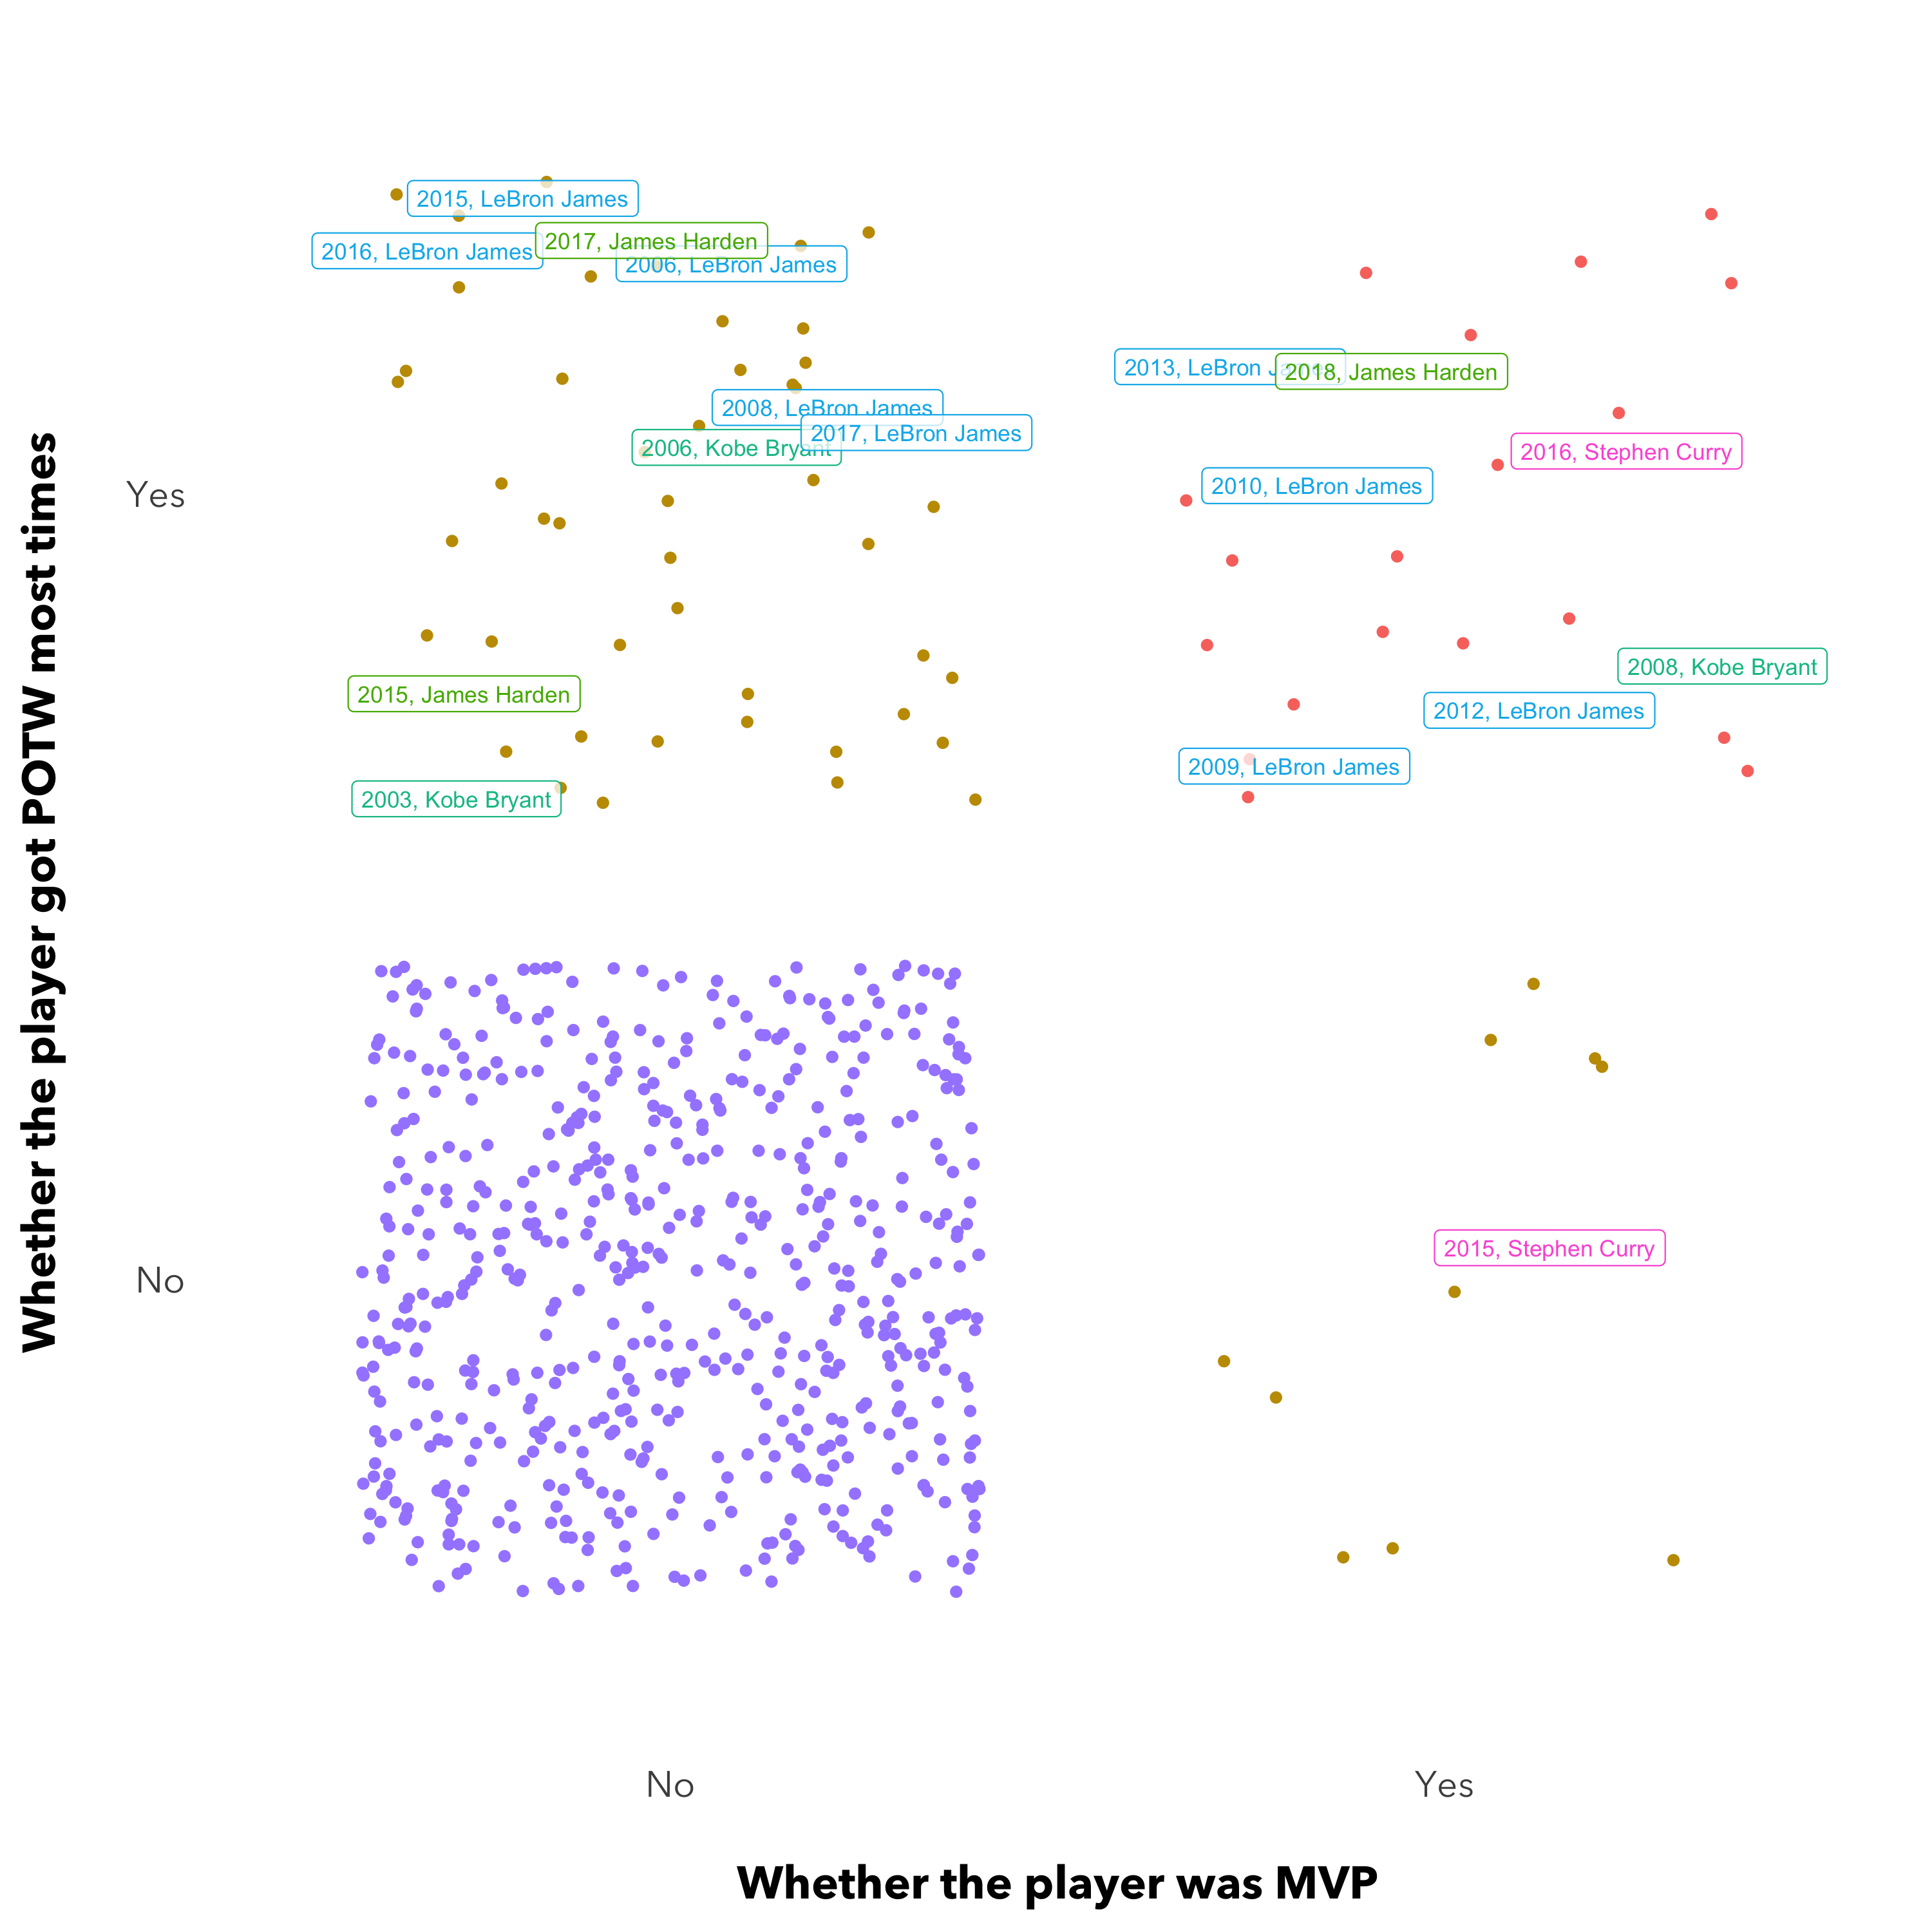

In [20]:
%%R -w 10 -h 10 --units in -r 300
(ggplot() + geom_jitter(aes(x = Is_MVP, y = Is_Max,color = Group), data = potw_mvp_sum) +
 theme_minimal(base_size = 17) +
 guides(colour = F) +
 geom_label(aes(x = Is_MVP, y = Is_Max, label = year_name, color = Player), 
            data = labeled_case, position = 'jitter', size = 3, alpha = 0.75) +
 ylab("Whether the player got POTW most times \n") + 
 xlab("\nWhether the player was MVP") +
 theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
       panel.grid.major = element_blank(),
       panel.grid.minor = element_blank())
)